<a href="https://colab.research.google.com/github/beyzoskaya/PyTorch_deepLearning/blob/main/extras/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython import display
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

In [9]:
import os
def mnist_data(data_dir='./data'):
  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.5], std=[0.5])
  ])

  os.makedirs(data_dir, exist_ok=True)

  mnist_dataset = datasets.MNIST(root=data_dir,
                                 train=True,
                                 transform=transform,
                                 download=True
                                 )
  return mnist_dataset

data_dir = './mnist_data'
# Load the data
mnist_dataset = mnist_data(data_dir)

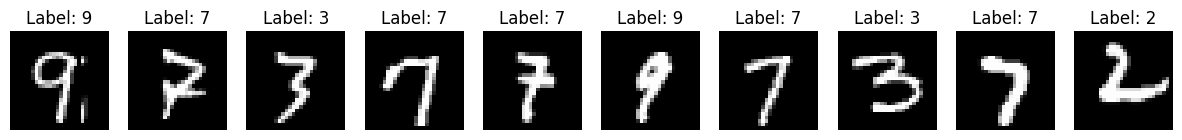

In [10]:
import matplotlib.pyplot as plt

def show_images(images, labels, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.set_title(f"Label: {labels[i]}")
        ax.axis('off')
    plt.show()

batch_size = 10
data_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)
images, labels = next(iter(data_loader))

show_images(images, labels, num_images=batch_size)


In [30]:
from torch import nn
class DiscriminatorNet(torch.nn.Module):
  def __init__(self):
    super(DiscriminatorNet, self).__init__()
    number_of_features = 784
    number_of_out = 1

    self.layer_1 = nn.Sequential(
        nn.Linear(number_of_features, out_features=1024),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3)
    )
    self.layer_2 = nn.Sequential(
        nn.Linear(in_features=1024, out_features=512),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3)
    )
    self.layer_3 = nn.Sequential(
        nn.Linear(in_features=512, out_features=256),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3)
    )
    self.classify = nn.Sequential(
        torch.nn.Linear(in_features=256, out_features=number_of_out),
        torch.nn.Sigmoid()
    )

  def forward(self,x):
    x = self.layer_1(x)
    x = self.layer_2(x)
    x = self.layer_3(x)
    x = self.classify(x)

    return x

def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

In [31]:
class GeneratorNet(torch.nn.Module):
  def __init__(self):
    super(GeneratorNet, self).__init__()
    number_of_features = 100
    number_out = 784

    self.layer_1 = nn.Sequential(
        nn.Linear(in_features=number_of_features, out_features=256),
        nn.LeakyReLU(0.2)
    )
    self.layer_2 = nn.Sequential(
        nn.Linear(in_features=256, out_features=512),
        nn.LeakyReLU(0.2)
    )
    self.layer_3 = nn.Sequential(
        nn.Linear(in_features=512, out_features=1024),
        nn.LeakyReLU(0.2)
    )
    self.classify = nn.Sequential(
        nn.Linear(in_features=1024, out_features=number_out),
        nn.Tanh()
    )

  def forward(self,x):
    x = self.layer_1(x)
    x = self.layer_2(x)
    x = self.layer_3(x)
    x = self.classify(x)

    return x

def noise(noise_size):
  n = Variable(torch.randn(noise_size, 100))
  if torch.cuda.is_available(): return n.cuda()
  return n

In [32]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()

if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

In [33]:
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
generator_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

loss_fn = torch.nn.BCELoss()

number_of_discriminator_steps = 1
num_of_epochs = 100

In [39]:
def real_data_target(size):
  data = Variable(torch.ones(size, 1))
  if torch.cuda.is_available(): return data.cuda()
  return data

def fake_data_target(size):
  data = Variable(torch.zeros(size, 1))
  if torch.cuda.is_available(): return data.cuda()
  return data

In [51]:
def train_discriminator(optimizer, real_data, fake_data):
    optimizer.zero_grad()

    # Train on Real Data
    prediction_real = discriminator(real_data)

    error_real = loss_fn(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # Train on Fake Data
    prediction_fake = discriminator(fake_data)

    error_fake = loss_fn(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()


    optimizer.step()


    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):

    optimizer.zero_grad()

    prediction = discriminator(fake_data)

    error = loss_fn(prediction, real_data_target(prediction.size(0)))
    error.backward()

    optimizer.step()
    return error

In [52]:
test_samples = 16
test_noise = noise(test_samples)

In [ ]:
for epoch in range(num_of_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):
      real_data = Variable(images_to_vectors(real_batch))
      if torch.cuda.is_available(): real_data = real_data.cuda()
      fake_data = generator(noise(real_data.size(0))).detach()
      d_error, d_pred_real, d_pred_fake = train_discriminator(discriminator_optimizer,
                                                                real_data, fake_data)

      fake_data = generator(noise(real_batch.size(0)))

      generator_error = train_generator(generator_optimizer, fake_data)